epoch 0  | loss: 0.0     |  0:00:00s
epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 7  | loss: 0.0     |  0:00:00s
epoch 8  | loss: 0.0     |  0:00:00s
epoch 9  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 14 | loss: 0.0     |  0:00:00s
epoch 15 | loss: 0.0     |  0:00:00s
epoch 16 | loss: 0.0     |  0:00:00s
epoch 17 | loss: 0.0     |  0:00:00s
epoch 18 | loss: 0.0     |  0:00:00s
epoch 19 | loss: 0.0     |  0:00:00s
epoch 20 | loss: 0.0     |  0:00:00s
epoch 21 | loss: 0.0     |  0:00:00s
epoch 22 | loss: 0.0     |  0:00:00s
epoch 23 | loss: 0.0     |  0:00:00s
epoch 24 | loss: 0.0     |  0:00:00s
epoch 25 | loss: 0.0     |  0:00:00s
epoch 26 | loss: 0.0     |  0:00:00s
e

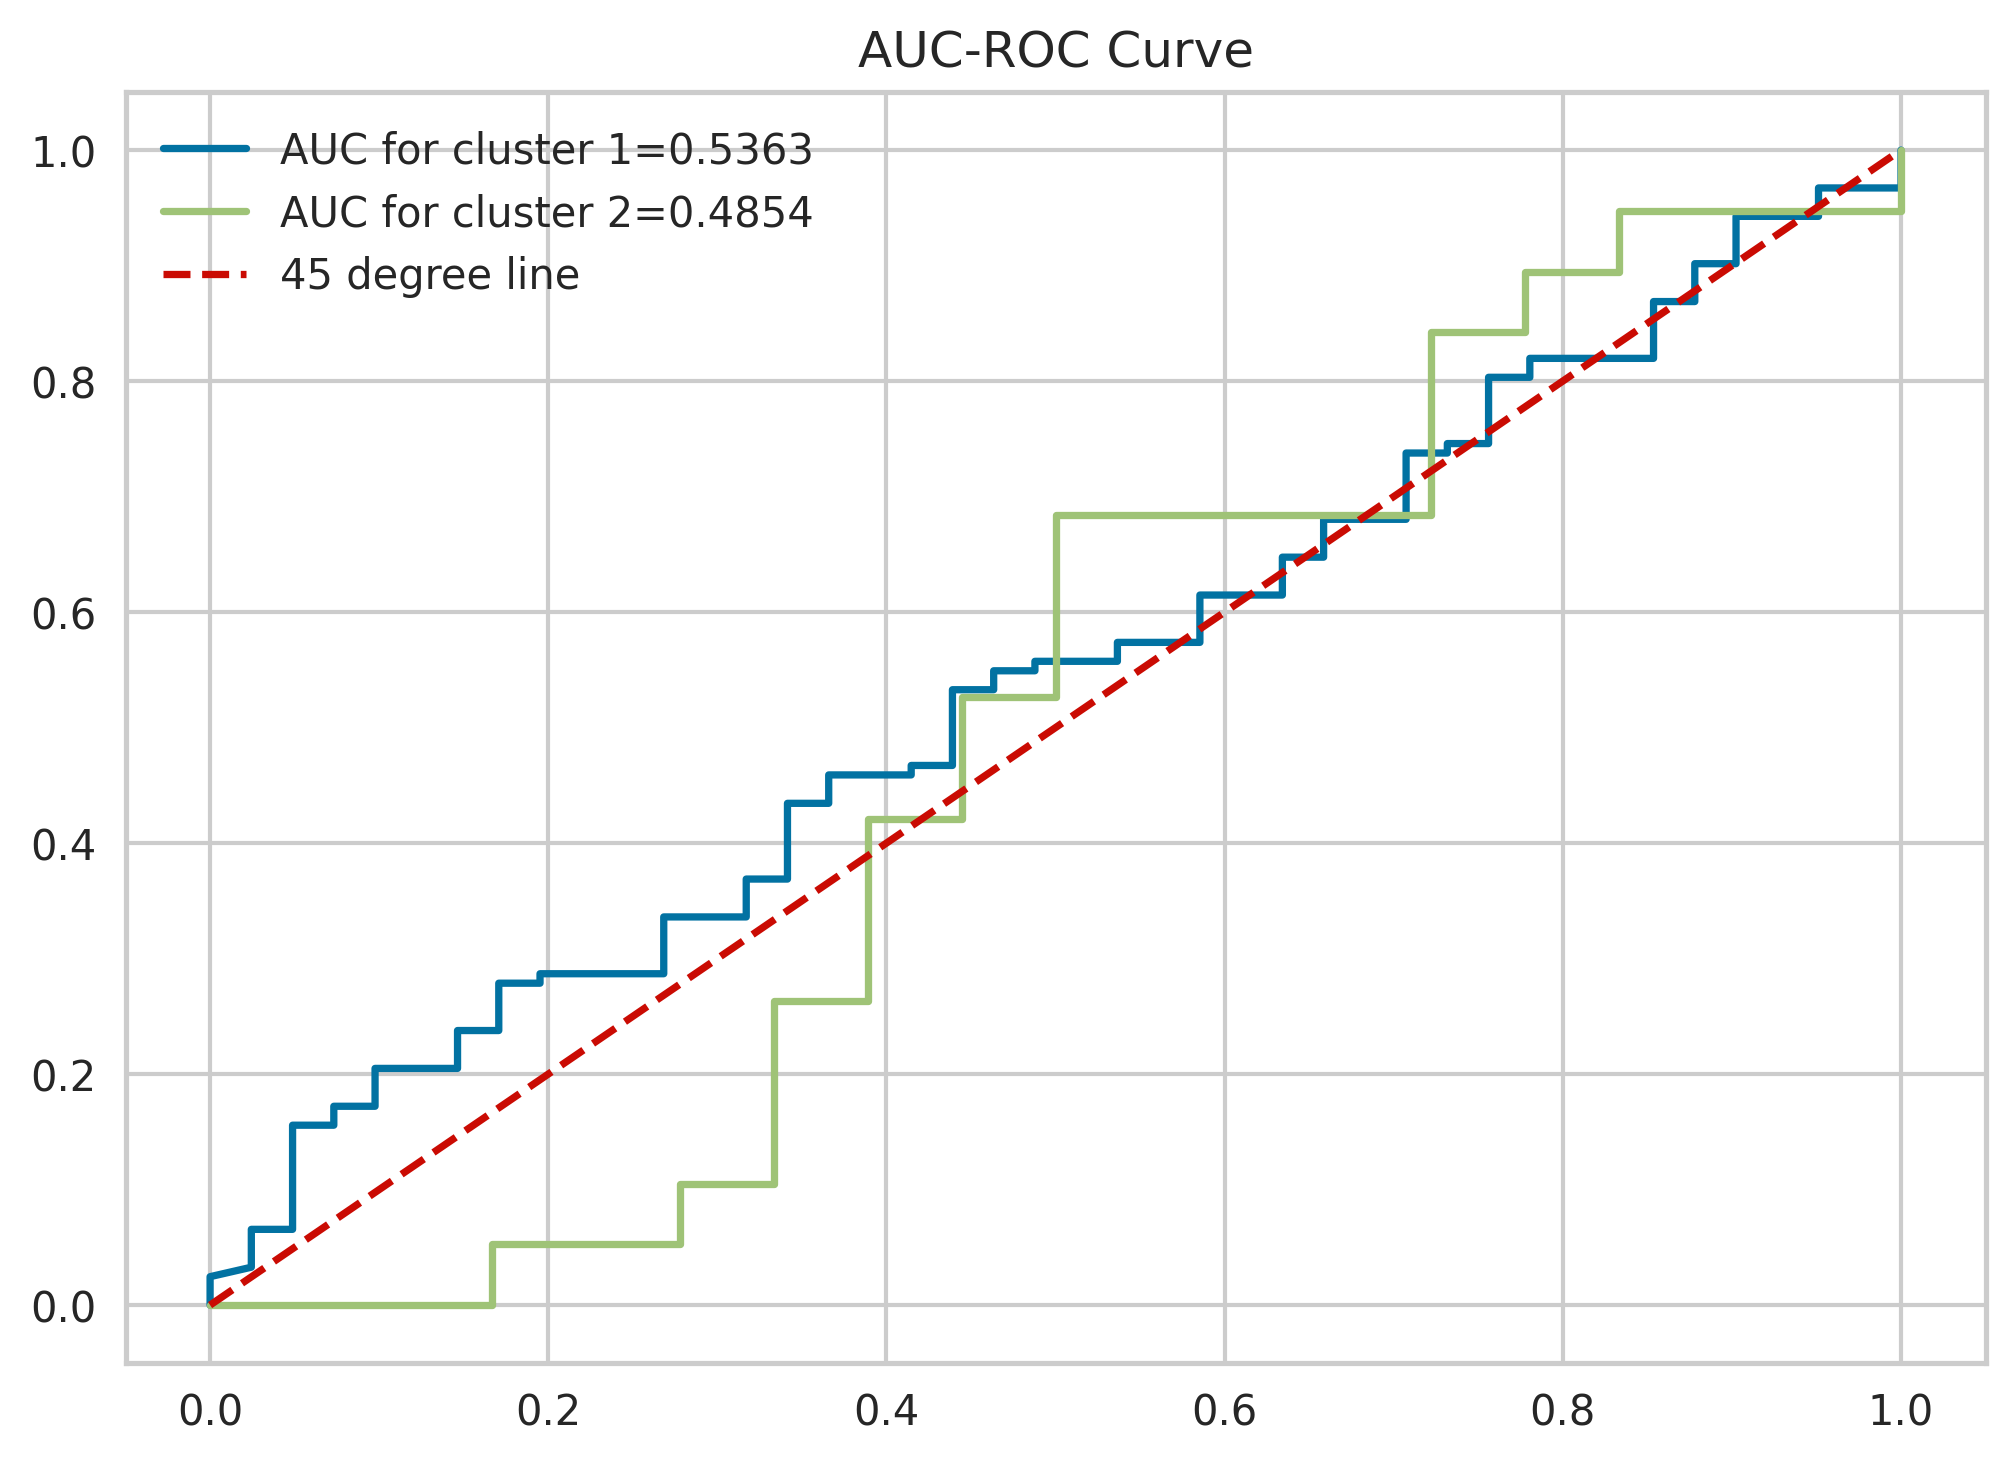

In [15]:
import numpy as np
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from imblearn.combine import SMOTEENN

# Separate data based on clusters
first_cluster_train = X_train[X_train.Clusters == 0].iloc[:, :-1]
second_cluster_train = X_train[X_train.Clusters == 1].iloc[:, :-1]
first_cluster_test = X_test[X_test.Clusters == 0].iloc[:, :-1]
second_cluster_test = X_test[X_test.Clusters == 1].iloc[:, :-1]

# Convert Pandas DataFrame to numpy array
X_train1 = np.array(first_cluster_train)
y_train1 = np.array(y_train[y_train.Clusters == 0]['Risk'].ravel())
X_train2 = np.array(second_cluster_train)
y_train2 = np.array(y_train[y_train.Clusters == 1]['Risk'].ravel())

# Resample using SMOTEENN
smote = SMOTEENN(random_state=2)
X_train1, y_train1 = smote.fit_resample(X_train1, y_train1)
X_train2, y_train2 = smote.fit_resample(X_train2, y_train2)

# Train TabNet models on each cluster
clf1 = TabNetClassifier()
clf1.fit(X_train1, y_train1)

clf2 = TabNetClassifier()
clf2.fit(X_train2, y_train2)

# Predict probabilities on test set
pred_prob1 = clf1.predict_proba(np.array(first_cluster_test))[:, 1]
pred_prob2 = clf2.predict_proba(np.array(second_cluster_test))[:, 1]

# Plot AUC-ROC curves
false_pos, true_pos, _ = roc_curve(y_test[y_test.Clusters == 0]['Risk'].values, pred_prob1)
auc = roc_auc_score(y_test[y_test.Clusters == 0]['Risk'], pred_prob1)
plt.plot(false_pos, true_pos, label="AUC for cluster 1={:.4f}".format(auc))

false_pos, true_pos, _ = roc_curve(y_test[y_test.Clusters == 1]['Risk'].values, pred_prob2)
auc = roc_auc_score(y_test[y_test.Clusters == 1]['Risk'], pred_prob2)
plt.plot(false_pos, true_pos, label="AUC for cluster 2={:.4f}".format(auc))

plt.plot([0, 1], [0, 1], linestyle='--', label='45 degree line')
plt.legend(loc='best')
plt.title('AUC-ROC Curve')
plt.show()


In [67]:
import numpy as np
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from imblearn.combine import SMOTEENN
from imblearn import over_sampling
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

first_cluster_train = X_train[X_train.Clusters == 0].iloc[:, :-1]
second_cluster_train = X_train[X_train.Clusters == 1].iloc[:, :-1]
first_cluster_test = X_test[X_test.Clusters == 0].iloc[:, :-1]
second_cluster_test = X_test[X_test.Clusters == 1].iloc[:, :-1]


X_train1 = np.array(first_cluster_train)
y_train1 = np.array(y_train[y_train.Clusters == 0]['Risk'].ravel())
X_train2 = np.array(second_cluster_train)
y_train2 = np.array(y_train[y_train.Clusters == 1]['Risk'].ravel())

# Create GAN to generate synthetic samples
def build_gan(input_dim):
    generator = Sequential([
        Dense(128, input_dim=input_dim, activation='relu'),
        Dense(64, activation='relu'),
        Dense(input_dim, activation='tanh'),
    ])
    
    discriminator = Sequential([
        Dense(64, input_dim=input_dim, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid'),
    ])
    
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate =0.0002, beta_1=0.5))
    
    gan_input = Input(shape=(input_dim,))
    gan_output = discriminator(generator(gan_input))
    gan = Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate =0.0002, beta_1=0.5))
    
    return generator, discriminator, gan

# Train GAN to generate synthetic samples of minority class
def train_gan(X_train, y_train, generator, discriminator, gan, epochs=1000, batch_size=32):
    early_stop = EarlyStopping(monitor='val_loss', patience=10)
    for epoch in range(epochs):
        real_samples = X_train[y_train == 1]
        # Generate synthetic samples using the generator network
        noise = np.random.normal(0, 1, size=(len(real_samples), X_train.shape[1]))
        fake_samples = generator.predict(noise)
        y = np.hstack([np.ones(len(real_samples)), np.zeros(len(fake_samples))])
        X = np.vstack([real_samples, fake_samples])
        discriminator.train_on_batch(X, y)
        noise = np.random.normal(0, 1, size=X_train.shape) 
        gan.train_on_batch(noise, np.ones(X_train.shape[0]))              
# Generate synthetic samples of minority class using trained GAN
def generate_samples(X_train, y_train, generator, batch_size=32):
    num_samples = X_train.shape[0] - np.sum(y_train == 1)
    batch,_ = divmod(num_samples,batch_size)
    batch+= int(bool(_))

    synthetic_samples = []
    for i in range(batch):
        noise = np.random.normal(0, 1, (batch, X_train.shape[1]))
        generated_samples = generator.predict(noise)
        synthetic_samples.append(generated_samples)

    synthetic_samples = np.concatenate(synthetic_samples, axis=0)

    return synthetic_samples

generator1, discriminator1, gan1 = build_gan(X_train1.shape[1])
train_gan(X_train1, y_train1, generator1, discriminator1, gan1)

generator2, discriminator2, gan2 = build_gan(X_train2.shape[1])
train_gan(X_train2, y_train2, generator2, discriminator2, gan2)

synthetic_samples1 = generate_samples(X_train1,y_train1, generator1)
synthetic_samples2 = generate_samples(X_train2, y_train2, generator2)

X_train1_balanced = np.concatenate([X_train1, synthetic_samples1])
y_train1_balanced = np.concatenate([y_train1, np.ones(len(synthetic_samples1))])

X_train2_balanced = np.concatenate([X_train2, synthetic_samples2])
y_train2_balanced = np.concatenate([y_train2, np.ones(len(synthetic_samples2))])



15/15 [==============================] - 0s 3ms/step


2023-03-23 16:12:04.109435: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 20ms/step


In [68]:
X_train1_balanced.shape,X_train1.shape,X_train2_balanced.shape,X_train2.shape

((628, 4), (603, 4), (206, 4), (197, 4))

epoch 0  | loss: 0.0     |  0:00:00s
epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 7  | loss: 0.0     |  0:00:00s
epoch 8  | loss: 0.0     |  0:00:00s
epoch 9  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 14 | loss: 0.0     |  0:00:00s
epoch 15 | loss: 0.0     |  0:00:00s
epoch 16 | loss: 0.0     |  0:00:00s
epoch 17 | loss: 0.0     |  0:00:00s
epoch 18 | loss: 0.0     |  0:00:00s
epoch 19 | loss: 0.0     |  0:00:00s
epoch 20 | loss: 0.0     |  0:00:00s
epoch 21 | loss: 0.0     |  0:00:00s
epoch 22 | loss: 0.0     |  0:00:00s
epoch 23 | loss: 0.0     |  0:00:00s
epoch 24 | loss: 0.0     |  0:00:00s
epoch 25 | loss: 0.0     |  0:00:00s
epoch 26 | loss: 0.0     |  0:00:00s
e

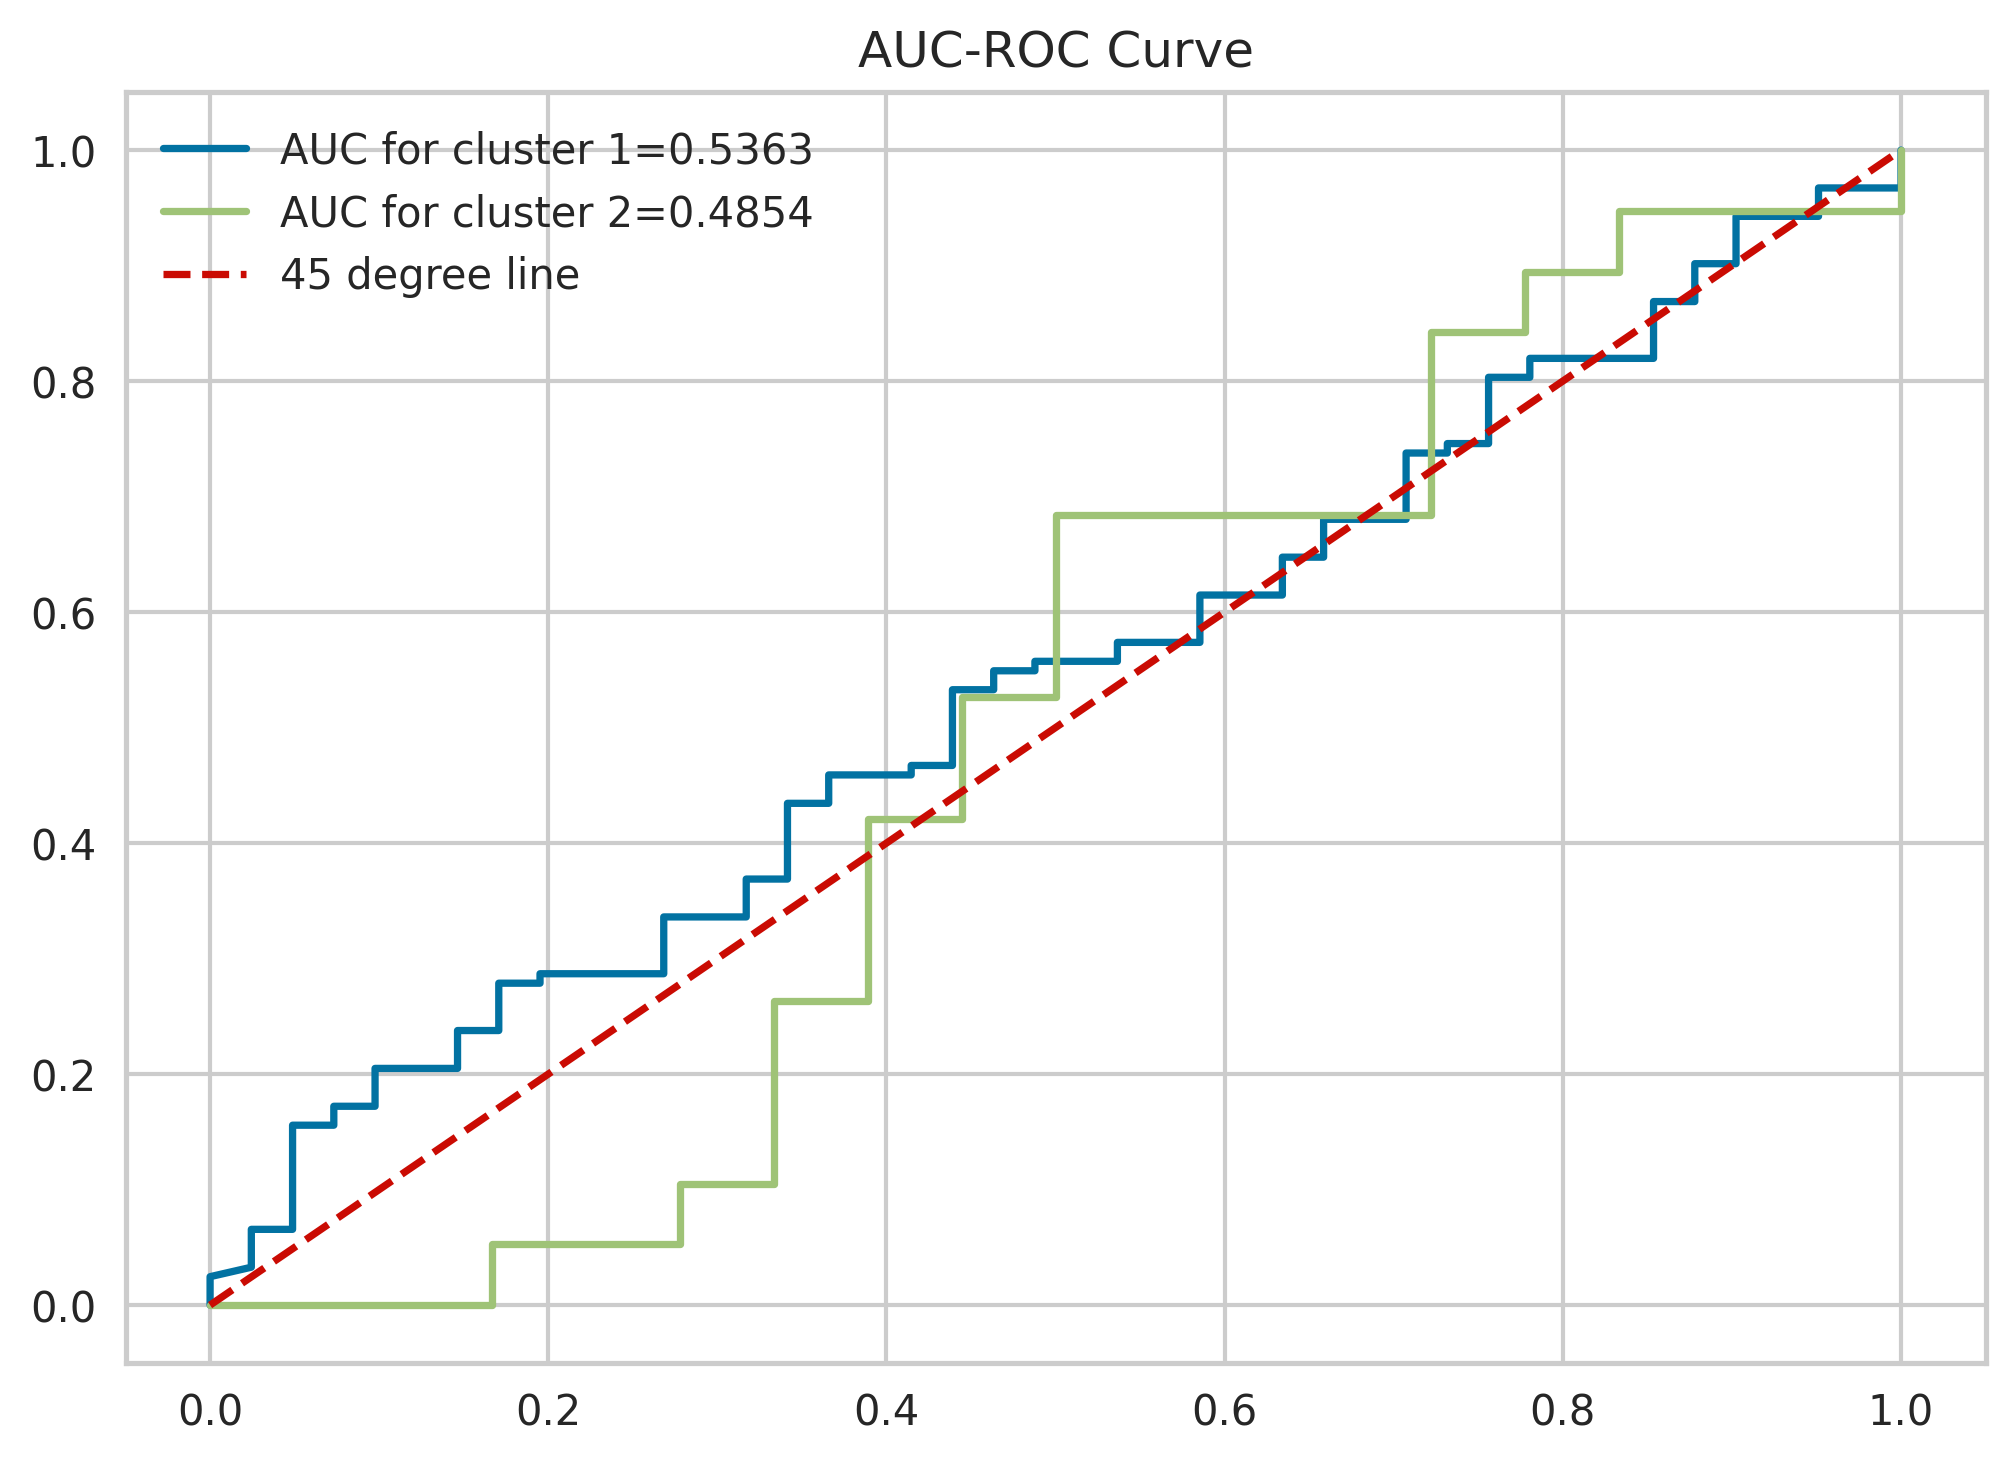

In [69]:

# Train TabNet models on each cluster
clf1 = TabNetClassifier()
clf1.fit(X_train1_balanced, y_train1_balanced)

clf2 = TabNetClassifier()
clf2.fit(X_train2_balanced, y_train2_balanced)

# Predict probabilities on test set
pred_prob1 = clf1.predict_proba(np.array(first_cluster_test))[:, 1]
pred_prob2 = clf2.predict_proba(np.array(second_cluster_test))[:, 1]

# Plot AUC-ROC curves
false_pos, true_pos, _ = roc_curve(y_test[y_test.Clusters == 0]['Risk'].values, pred_prob1)
auc = roc_auc_score(y_test[y_test.Clusters == 0]['Risk'], pred_prob1)
plt.plot(false_pos, true_pos, label="AUC for cluster 1={:.4f}".format(auc))

false_pos, true_pos, _ = roc_curve(y_test[y_test.Clusters == 1]['Risk'].values, pred_prob2)
auc = roc_auc_score(y_test[y_test.Clusters == 1]['Risk'], pred_prob2)
plt.plot(false_pos, true_pos, label="AUC for cluster 2={:.4f}".format(auc))

plt.plot([0, 1], [0, 1], linestyle='--', label='45 degree line')
plt.legend(loc='best')
plt.title('AUC-ROC Curve')
plt.show()
